In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow, show
tf.config.threading.set_intra_op_parallelism_threads(3)
tf.config.threading.set_inter_op_parallelism_threads(3)

Load VGG-19

In [2]:
def content_cost(content_image,generated_image):
    # content_image 1, H , W , C
    # generated 1, H , W , C
    m, H, W , C=content_image.shape
    normalise = 1/(H*W*C)
    return normalise*tf.reduce_sum((content_image-generated_image)**2)


In [3]:
# Test
tf.random.set_seed(1)
content_image_test=tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
generated_image_test=tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
content_cost(content_image=content_image_test,generated_image=generated_image_test)

<tf.Tensor: shape=(), dtype=float32, numpy=28.227509>

In [4]:
# These images have already been passed through model
def gram(image):
    # expects 1, H , W ,C
    m, H, W , C=image.shape
    new_shape=tf.reshape(image,[H*W,C])

    return tf.matmul(tf.transpose(new_shape),new_shape)


In [5]:
# Test
tf.random.set_seed(1)
image_test=tf.random.normal([1, 4, 4, 2], mean=1, stddev=4)
gram(image_test)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[218.06528, -22.36548],
       [-22.36548, 178.64575]], dtype=float32)>

In [6]:
# def style cost function
def layer_style_cost(style_image,generated_image):
    # style_image 1, H , W , C
    # generated_image 1, H , W , C
    
    m, H, W , C=style_image.shape
    # Calc gram
    style_image_gram=gram(style_image)
    generated_image_gram=gram(generated_image)
    normalise = 1/((H*W*C)**2)
    return normalise*tf.reduce_sum((style_image_gram-generated_image_gram)**2)

In [7]:
# Test
tf.random.set_seed(1)
style_image_test=tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
generated_image_test=tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
layer_style_cost(style_image=style_image_test,generated_image=generated_image_test)

<tf.Tensor: shape=(), dtype=float32, numpy=56.07123>

In [8]:
# Style cost
def style_cost(weights,generated_image_layers,style_layers):
    # weights x
    # generated_image_layers m , H , W , C
    # generated_style_layers m , H , W , C 
    cost=0
    m , H, W, C = generated_image_test.shape
    for index in range(m):
        cost+=weights[index]*layer_style_cost(style_layers[index],generated_image_layers[index])
    return cost


In [9]:
size_of_images=(1,300,300,3)

In [10]:
vgg_model=keras.applications.VGG19(include_top=False,input_shape=(300,300,3),pooling="avg")

In [11]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [12]:
STYLE_LAYERS = np.array([
    ('block1_conv2', 0.2),
    ('block2_conv2', 0.2),
    ('block3_conv2', 0.2),
    ('block4_conv2', 0.2),
    ('block5_conv2', 0.2)])

In [13]:
# Our style layers
style_layers_tensors=[vgg_model.get_layer(style_layer).output for style_layer in STYLE_LAYERS[:,0]]
# Our content layer
content_layers_tensors=[vgg_model.get_layer('block3_conv4').output]


In [14]:
model = keras.Model(inputs=vgg_model.input, outputs=[*style_layers_tensors, *content_layers_tensors])

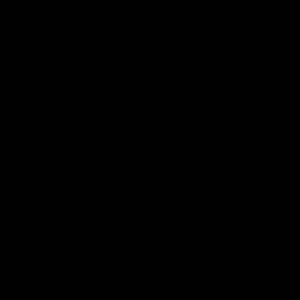

In [15]:
generated_image=np.random.randint(low=0,high=255,size=size_of_images,dtype=np.uint8).astype(np.float32)
generated_image=np.zeros(size_of_images).astype(np.float32)
Image.fromarray(np.array(generated_image[0],dtype=np.uint8))

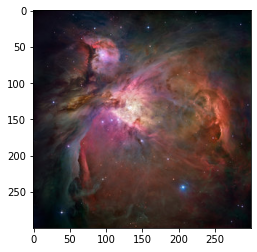

In [16]:
style_image=np.array(Image.open('style.jpg'))
# style_image=np.array(Image.open('style2.jpg').resize((300,300)))
imshow(style_image)

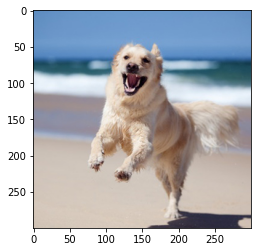

In [17]:
content_image=np.array(Image.open('content.jpg'))
imshow(content_image)

In [18]:
optimiser=tf.keras.optimizers.Adam(learning_rate=3)


In [19]:
# @tf.function
# def train_step(content_generator_value,style_generator_value,generated_image):
#     with tf.GradientTape() as tape:
#         loss=0.25*content_cost(content_image_value,content_generator_value) + 0.25*style_cost(weights=STYLE_LAYERS[:,1],generated_image_layers=style_generator_value,style_layers=style_image_values)
#     gradient = tape.gradient(loss, generated_image)
#     print(gradient)
#     optimiser.apply_gradients([(gradient, generated_image)])

tf.Tensor(38773.98, shape=(), dtype=float32)


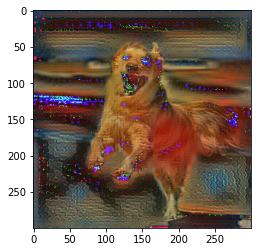

tf.Tensor(38761.496, shape=(), dtype=float32)
tf.Tensor(38749.14, shape=(), dtype=float32)
tf.Tensor(38736.61, shape=(), dtype=float32)
tf.Tensor(38723.945, shape=(), dtype=float32)
tf.Tensor(38711.617, shape=(), dtype=float32)
tf.Tensor(38699.016, shape=(), dtype=float32)
tf.Tensor(38686.566, shape=(), dtype=float32)
tf.Tensor(38674.105, shape=(), dtype=float32)
tf.Tensor(38661.64, shape=(), dtype=float32)
tf.Tensor(38649.027, shape=(), dtype=float32)
tf.Tensor(38636.566, shape=(), dtype=float32)
tf.Tensor(38624.125, shape=(), dtype=float32)
tf.Tensor(38611.7, shape=(), dtype=float32)
tf.Tensor(38599.32, shape=(), dtype=float32)
tf.Tensor(38587.02, shape=(), dtype=float32)
tf.Tensor(38574.52, shape=(), dtype=float32)
tf.Tensor(38562.273, shape=(), dtype=float32)
tf.Tensor(38549.848, shape=(), dtype=float32)
tf.Tensor(38537.34, shape=(), dtype=float32)
tf.Tensor(38524.977, shape=(), dtype=float32)


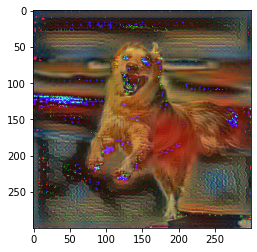

tf.Tensor(38512.543, shape=(), dtype=float32)
tf.Tensor(38500.18, shape=(), dtype=float32)
tf.Tensor(38487.875, shape=(), dtype=float32)
tf.Tensor(38475.453, shape=(), dtype=float32)
tf.Tensor(38463.13, shape=(), dtype=float32)
tf.Tensor(38450.812, shape=(), dtype=float32)
tf.Tensor(38438.574, shape=(), dtype=float32)
tf.Tensor(38426.15, shape=(), dtype=float32)
tf.Tensor(38413.723, shape=(), dtype=float32)
tf.Tensor(38401.742, shape=(), dtype=float32)
tf.Tensor(38389.223, shape=(), dtype=float32)
tf.Tensor(38376.89, shape=(), dtype=float32)
tf.Tensor(38364.67, shape=(), dtype=float32)
tf.Tensor(38352.434, shape=(), dtype=float32)
tf.Tensor(38340.29, shape=(), dtype=float32)
tf.Tensor(38328.027, shape=(), dtype=float32)
tf.Tensor(38315.875, shape=(), dtype=float32)
tf.Tensor(38303.46, shape=(), dtype=float32)
tf.Tensor(38291.33, shape=(), dtype=float32)
tf.Tensor(38279.414, shape=(), dtype=float32)


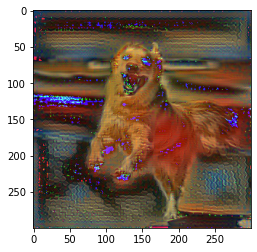

tf.Tensor(38267.117, shape=(), dtype=float32)
tf.Tensor(38255.117, shape=(), dtype=float32)
tf.Tensor(38242.965, shape=(), dtype=float32)
tf.Tensor(38230.953, shape=(), dtype=float32)
tf.Tensor(38218.81, shape=(), dtype=float32)
tf.Tensor(38206.727, shape=(), dtype=float32)
tf.Tensor(38194.746, shape=(), dtype=float32)
tf.Tensor(38182.74, shape=(), dtype=float32)
tf.Tensor(38170.69, shape=(), dtype=float32)
tf.Tensor(38158.547, shape=(), dtype=float32)
tf.Tensor(38146.434, shape=(), dtype=float32)
tf.Tensor(38134.395, shape=(), dtype=float32)
tf.Tensor(38122.594, shape=(), dtype=float32)
tf.Tensor(38110.457, shape=(), dtype=float32)
tf.Tensor(38098.32, shape=(), dtype=float32)
tf.Tensor(38086.555, shape=(), dtype=float32)
tf.Tensor(38074.43, shape=(), dtype=float32)
tf.Tensor(38062.47, shape=(), dtype=float32)
tf.Tensor(38050.566, shape=(), dtype=float32)
tf.Tensor(38038.75, shape=(), dtype=float32)


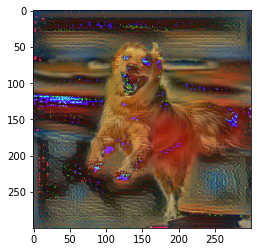

tf.Tensor(38026.605, shape=(), dtype=float32)
tf.Tensor(38014.77, shape=(), dtype=float32)
tf.Tensor(38002.844, shape=(), dtype=float32)
tf.Tensor(37990.938, shape=(), dtype=float32)
tf.Tensor(37979.13, shape=(), dtype=float32)
tf.Tensor(37967.113, shape=(), dtype=float32)
tf.Tensor(37955.23, shape=(), dtype=float32)
tf.Tensor(37943.316, shape=(), dtype=float32)


In [21]:
epochs=20000
# pass content image through model
content_image_value=model(content_image.reshape(size_of_images))[-1]
# pass styles image through model
style_image_values=model(style_image.reshape(size_of_images))[:-1]

generated_image=tf.Variable(generated_image, trainable=True)
# print(generated_image.numpy())
for epoch in range(epochs):
    generate_image_values=model(generated_image)
    content_generator_value=generate_image_values[-1]
    style_generator_value=generate_image_values[:-1]
    # train_step(content_generator_value,style_generator_value,generated_image)
    with tf.GradientTape() as tape:
        tape.watch(generated_image)
        generate_image_values = model(generated_image)
        # Get the output we compare with the content
        content_generator_value = generate_image_values[-1]
        # Get the output we compare with the style
        style_generator_value = generate_image_values[:-1]
        loss=0.25*content_cost(content_image_value,content_generator_value) + 0.25*style_cost(weights=STYLE_LAYERS[:,1],generated_image_layers=style_generator_value,style_layers=style_image_values)
 # returns a float64
    print(loss)
# Get the gradients
    grads = tape.gradient(loss, [generated_image])
# minimize
    optimiser.apply_gradients(zip(grads, [generated_image]))
    if epoch%20 ==0:
        imshow(np.array(generated_image[0],dtype=np.uint8))
        show()
# loss=0.25*content_cost(content_image_value,content_generator_value) + 0.25*style_cost(weights=STYLE_LAYERS[:,1],generated_image_layers=style_generator_value,style_layers=style_image_values)
    # print(loss)
    # optimiser.minimize(loss,var_list=[generated_image])
    # print(generated_image.shape)
    # imshow(generated_image[0])